## Project Title: Air Quality Predictor using PyTorch LSTM 🌤️

### 1. Data Collection & Exploration 🗂
- Load PRSA air quality dataset
- Explore initial data structure
- Identify relevant features
- Load and explore the data

### 2. Data Preprocessing 🔄
- DateTime processing
- Missing values treatment

### 3. Feature Engineering 📊
- Categorical encoding
- Time aggregation
- Data analysis and visualization
- LSTM sequence preparation

### 4. Data Splitting 📊
- Train-test split
- Validation set creation if needed

### 5. Model Development & Training ⚙️
- Define model architecture
- Set hyperparameters
- Training loop
- Loss tracking
- Visualization

### 6. Model Evaluation 📈
- Test set evaluation
- Performance metrics
- Feature-wise predictions

### 7. Results & Analysis 🎯
- Compare predictions vs actual data
- Feature-wise performance
- Visualization of results


## Long Short-Term Memory (LSTM)

### Introduction 🔍
- A type of Recurrent Neural Network (RNN) designed to process and predict sequences of data like time series or text

### Why LSTM? 🤔
- Handles long sequences: Remembers information from earlier in the sequence, crucial for tasks like language processing
- Avoids Vanishing Gradient Problem
- Adaptability: Versatile across various problems involving sequential data

### Components ⚙️
- Memory Cell: Maintains information across the sequence, enabling the network to remember important data over long distances
- Gates:
    - Input Gate: Determines what new information should be added to the cell state
    - Output Gate: Controls what information should be output at the current time step
    - Forget Gate: Decides what information should be discarded


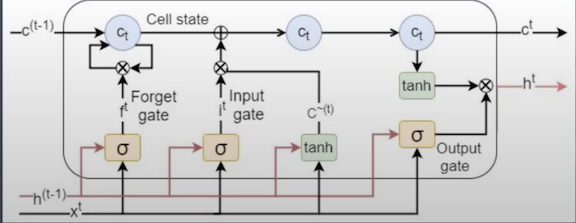


### Applications
- Text Generation: Generating poetry or song lyrics
- Time Series Forcasting: Predicting stock prices
- Speech Recognition: Converting spoken language to text
- Anomaly Detection in Sensor Data: Predictive maintenance in manufacturing
- Language Translation: Translating text from one language to another

## References
- [Beijing's PM2.5 Dataset Documentation](https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data)




In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 1. DATA COLLECTION - LOAD AND EXPLORE DATA

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'

df = pd.read_csv(url)

display(df.head())

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
# Consider necessary features (columns)

air_quality_features = [
    'year', 'month', 'day', 'hour',  # temporal features
     'pm2.5',                        # target
    'TEMP', 'cbwd', 'Iws'            # key weather parameters
]

df = df[air_quality_features]

print(df.head())

print('\nInitial data shape:', df.shape)

   year  month  day  hour  pm2.5  TEMP cbwd    Iws
0  2010      1    1     0    NaN -11.0   NW   1.79
1  2010      1    1     1    NaN -12.0   NW   4.92
2  2010      1    1     2    NaN -11.0   NW   6.71
3  2010      1    1     3    NaN -14.0   NW   9.84
4  2010      1    1     4    NaN -12.0   NW  12.97

Initial data shape: (43824, 8)


In [4]:
# 2. DATA PREPROCESSING

# Create datetime index
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']]
                    .assign(
                        hour=df.hour.astype(str).str.pad(2, fillchar='0')
                    ), format='%Y-%m-%d-%H')

# Ensure index is DatetimeIndex
df = df.set_index('datetime').sort_index()
df.index = pd.DatetimeIndex(df.index)

# Drop original time columns
df = df.drop(['year', 'month', 'day', 'hour'], axis=1)

print(df.head())

                     pm2.5  TEMP cbwd    Iws
datetime                                    
2010-01-01 00:00:00    NaN -11.0   NW   1.79
2010-01-01 01:00:00    NaN -12.0   NW   4.92
2010-01-01 02:00:00    NaN -11.0   NW   6.71
2010-01-01 03:00:00    NaN -14.0   NW   9.84
2010-01-01 04:00:00    NaN -12.0   NW  12.97


In [5]:
# Handle missing values
'''
    Observation: Over 2k rows have missing values for pm2.5 (target) out of total 44k rows
    
    Common approaches for handling NA values in time series for LSTM:
       - Forward Fill Method, Interpolation Method, Moving Average
    First 24 rows (0.05%) have no PM2.5 data, removing 24 rows won't significantly impact the LSTM model
    
    1. Missing Value Treatment:
       - Removing initial rows with no PM2.5 measurements
       - Handling remaining missing values using Interpolation Method (better for time series) 
    2. Data Cleaning: Ensuring data quality for LSTM modeling
'''

# Remove first 24 rows where PM2.5 values are missing
df_cleaned = df.iloc[24:].copy()

# Handle remaining missing values using time-based interpolation
df_cleaned['pm2.5'] = df_cleaned['pm2.5'].interpolate(method='time')

print('Dataset before preprocessing:', df.shape)
print("Missing PM2.5 values before:", df['pm2.5'].isna().sum())

display(df_cleaned.head())

print('\nDataset after preprocessing:', df_cleaned.shape)
print('Missing PM2.5 values after:', df_cleaned['pm2.5'].isna().sum())

Dataset before preprocessing: (43824, 4)
Missing PM2.5 values before: 2067


,pm2.5,TEMP,cbwd,Iws
datetime,,,,
2010-01-02 00:00:00,129.0,-4.0,SE,1.79
2010-01-02 01:00:00,148.0,-4.0,SE,2.68
2010-01-02 02:00:00,159.0,-5.0,SE,3.57
2010-01-02 03:00:00,181.0,-5.0,SE,5.36
2010-01-02 04:00:00,138.0,-5.0,SE,6.25



Dataset after preprocessing: (43800, 4)
Missing PM2.5 values after: 0


In [6]:
# 3. FEATURE ENGINEERING

# Use One-Hot Encoding to convert these categorical wind directions to numerical values

# Creates a new column for each unique value in 'cbwd'
wind_dummies = pd.get_dummies(df_cleaned['cbwd'], prefix='wind', dtype=int)

df_processed = pd.concat([df_cleaned, wind_dummies], axis=1)
df_processed = df_processed.drop('cbwd', axis=1)

print(df_processed.head())

                     pm2.5  TEMP   Iws  wind_NE  wind_NW  wind_SE  wind_cv
datetime                                                                  
2010-01-02 00:00:00  129.0  -4.0  1.79        0        0        1        0
2010-01-02 01:00:00  148.0  -4.0  2.68        0        0        1        0
2010-01-02 02:00:00  159.0  -5.0  3.57        0        0        1        0
2010-01-02 03:00:00  181.0  -5.0  5.36        0        0        1        0
2010-01-02 04:00:00  138.0  -5.0  6.25        0        0        1        0


In [7]:
# Time Aggregation

'''
Consider 6-Hour time aggregation Data (1460 points/year):
    - Better signal-to-noise ratio
    - More manageable sequence lengths, each sequence can cover more temporal context
    - Still captures daily patterns (4 readings per day morning/evening)
    - Provides enough data points for LSTM (approximately 7300 points over 5 years)
'''

# Define different aggregation methods for different column types
df_final = df_processed.resample('6h').agg({
    'pm2.5': 'mean',    # Average of PM2.5
    'TEMP': 'mean',     # Average of temperature
    'Iws': 'mean',      # Average of wind speed
    'wind_NE': 'max',   # If wind was NE at any point in 6h period
    'wind_NW': 'max',   # If wind was NW at any point in 6h period
    'wind_SE': 'max',   # If wind was SE at any point in 6h period
    'wind_cv': 'max'    # If wind was cv at any point in 6h period
})

print("Original hourly data:", df_processed.shape)

print("\nAfter 6-hour aggregation:", df_final.shape)
display(df_final.head())


Original hourly data: (43800, 7)

After 6-hour aggregation: (7300, 7)


,pm2.5,TEMP,Iws,wind_NE,wind_NW,wind_SE,wind_cv
datetime,,,,,,,
2010-01-02 00:00:00,144.000000,-4.833333,4.465000,0,0,1,0
2010-01-02 06:00:00,128.833333,-5.333333,14.075000,0,0,1,0
2010-01-02 12:00:00,157.833333,-5.000000,32.625000,0,0,1,0
2010-01-02 18:00:00,153.166667,-5.333333,48.275000,0,0,1,0
2010-01-03 00:00:00,70.166667,-6.833333,67.423333,0,0,1,0


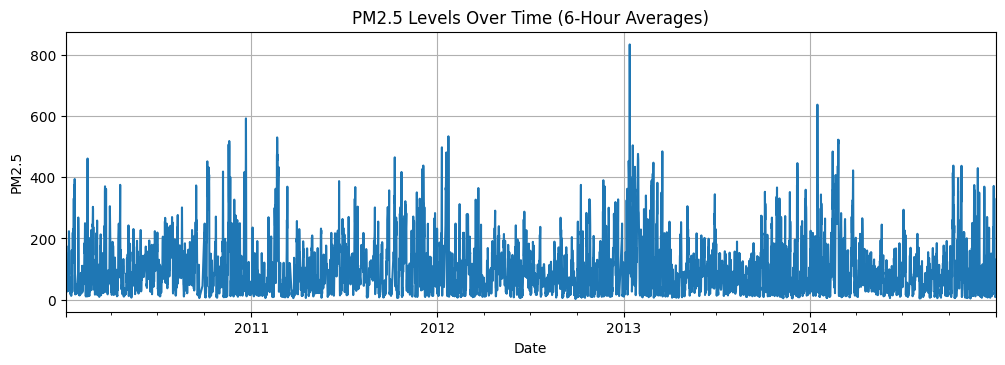

In [8]:
# Data Analysis and Visualization

#  Time Series of PM2.5 (6-hour intervals)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
df_final['pm2.5'].plot(title='PM2.5 Levels Over Time (6-Hour Averages)')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.grid(True)

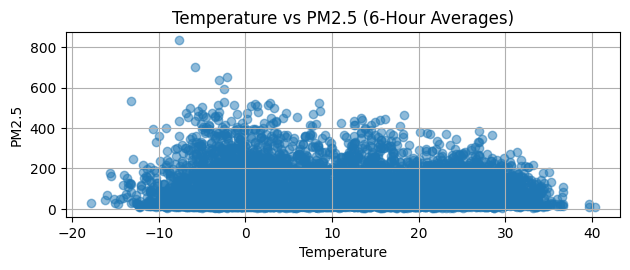

In [9]:
# Temperature vs PM2.5 (6-hour intervals)

plt.subplot(2, 1, 2)
plt.scatter(df_final['TEMP'], df_final['pm2.5'], alpha=0.5)
plt.title('Temperature vs PM2.5 (6-Hour Averages)')
plt.xlabel('Temperature')
plt.ylabel('PM2.5')
plt.grid(True)

plt.tight_layout()
plt.show()

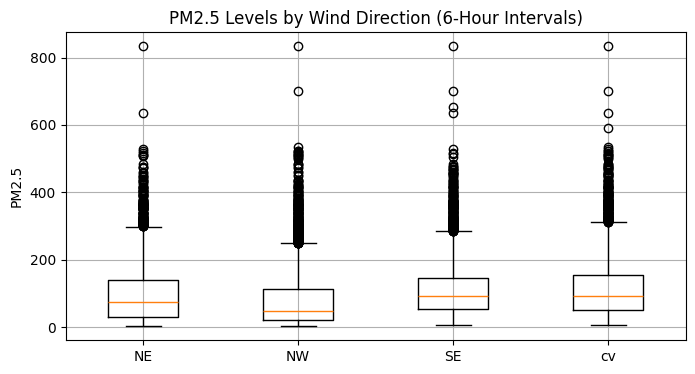

In [10]:
# PM2.5 by Wind Direction (6-hour intervals)
plt.figure(figsize=(8, 4))
wind_conditions = ['wind_NE', 'wind_NW', 'wind_SE', 'wind_cv']
pm25_by_wind = []
labels = []

for wind in wind_conditions:
    # Use == 1 instead of direct boolean indexing
    pm25_by_wind.append(df_final[df_final[wind] == 1]['pm2.5'])
    labels.append(wind.replace('wind_', ''))

plt.boxplot(pm25_by_wind, labels=labels)
plt.title('PM2.5 Levels by Wind Direction (6-Hour Intervals)')
plt.ylabel('PM2.5')
plt.grid(True)
plt.show()

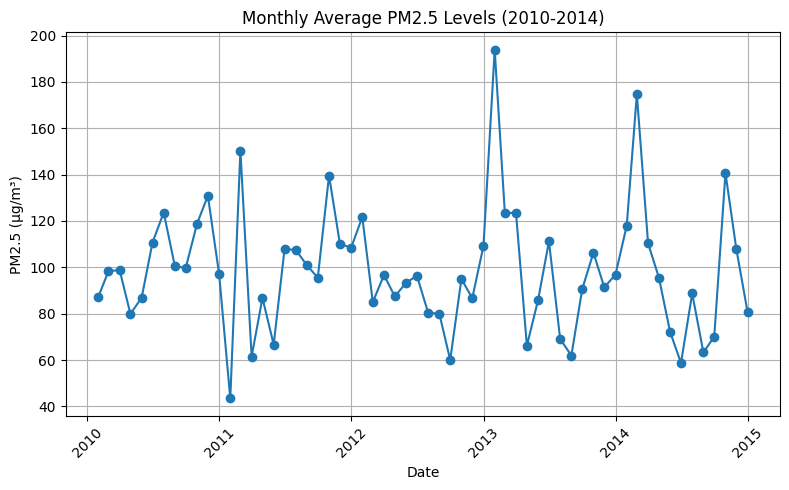

In [11]:
# Monthly average PM2.5 from 6-hour aggregated data
plt.figure(figsize=(8, 5))

# Calculate monthly average
monthly_avg = df_final['pm2.5'].resample('M').mean()

plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('Monthly Average PM2.5 Levels (2010-2014)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (μg/m³)')
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# LSTM Sequence Preparation

def create_sequences(data, seq_length):
    """
    Create sequences for LSTM model with multiple features
    Args:
        data: DataFrame with all features
        seq_length: Number of time steps (e.g., 28 for 7 days of 6-hour data)
    Returns:
        input_sequences: Input sequences (samples, time steps, features)
        target_sequences: Target values (samples, features)
    """
    input_sequences = []
    target_sequences = []
    
    # Convert DataFrame to numpy array if it isn't already
    if isinstance(data, pd.DataFrame):
        data = data.values
        
    for i in range(len(data) - seq_length):
        input_sequences.append(data[i:(i + seq_length)])
        target_sequences.append(data[i + seq_length])
    
    return np.array(input_sequences), np.array(target_sequences)

# Create sequences using all features
sequence_length = 28  # 7 days of 6-hour data
X, y = create_sequences(df_final, sequence_length)

print("Sequence shapes:")
print(f"X shape: {X.shape}")  # (n_samples, sequence_length, n_features)
print(f"y shape: {y.shape}")  # (n_samples, n_features)
print("\nFeatures included:", df_final.columns.tolist())

Sequence shapes:
X shape: (7272, 28, 7)
y shape: (7272, 7)

Features included: ['pm2.5', 'TEMP', 'Iws', 'wind_NE', 'wind_NW', 'wind_SE', 'wind_cv']


In [13]:
# 4. DATA SPLITTING - TRAIN, TEST & SPLIT! 

# Scale the data first
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# Then split into train and test data chronologically
train_size = int(len(X_scaled) * 0.8)

X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

print("Training set shapes:")
print(f"X_train: {X_train.shape}")  # (n_train_samples, sequence_length, features)
print(f"y_train: {y_train.shape}")  # (n_train_samples, features)

print("\nTest set shapes:")
print(f"X_test: {X_test.shape}")   # (n_test_samples, sequence_length, features)
print(f"y_test: {y_test.shape}") 

Training set shapes:
X_train: torch.Size([5817, 28, 7])
y_train: torch.Size([5817, 7])

Test set shapes:
X_test: torch.Size([1455, 28, 7])
y_test: torch.Size([1455, 7])


In [14]:
# shuffle=False : Keep temporal order for time series
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)

test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)  

In [15]:
# 5. MODEL DEVELOPMENT & TRAINING

from models.AirQualityPredictorLSTM import AirQualityPredictorLSTM

# Pick a Manual seed for randomization
torch.manual_seed(32)

# Get dimensions from your data
in_features = X_train.shape[2]  # number of features (pm2.5, TEMP, Iws, wind_NE, etc.)
hidden_size = 256  # you can adjust this hyperparameter
num_stacked_layers = 3  # number of LSTM layers stacked together
out_features = y_train.shape[1]  # same as in_features for this case

model = AirQualityPredictorLSTM(in_features, hidden_size, num_stacked_layers, out_features)

In [16]:
# Move model to device (CPU/GPU)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [17]:
# Set the criterion of model to measure the error, how far off the predictions are from the data
criterion = nn.L1Loss()  # This is MAE in PyTorch

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.005, 
    weight_decay=1e-5 # L2 regularization to prevent overfitting
)

# Initialize early stopping parameters
best_loss = float('inf')
patience = 15  # Allow more epochs without improvement since training is stable
best_model = None
counter = 0

In [18]:
import copy

# Epochs: One run through all the training data in our network
epochs = 200

# Keep track of the losses/errors, it has to decrease overtime that's how we know that the model/network is learning
train_losses = []

for epoch in range(epochs):
     # Set model to training mode
    model.train()
    total_loss = 0
     
    for batch_X, batch_y in train_loader:
        # Move batch data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        y_pred, _, _ = model(batch_X)  # No need to pass h0, c0 explicitly
        # Measure the loss
        loss = criterion(y_pred, batch_y) # Predicted values vs the y_train
        
        # Do some back propagation: Take the error rate of forward propagation and feed it back
        # through the network to fine tune the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
         # Store loss value
        total_loss += loss.item()
     
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        best_model = copy.deepcopy(model)
    else:
        counter += 1
    
    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        model = best_model  # Restore best model
        break

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')


Epoch [0/200], Loss: 0.3205
Epoch [10/200], Loss: 0.2549
Epoch [20/200], Loss: 0.2479
Epoch [30/200], Loss: 0.2441
Epoch [40/200], Loss: 0.2370
Epoch [50/200], Loss: 0.2339
Epoch [60/200], Loss: 0.2280
Epoch [70/200], Loss: 0.2231
Epoch [80/200], Loss: 0.2248
Epoch [90/200], Loss: 0.2227
Early stopping triggered at epoch 92


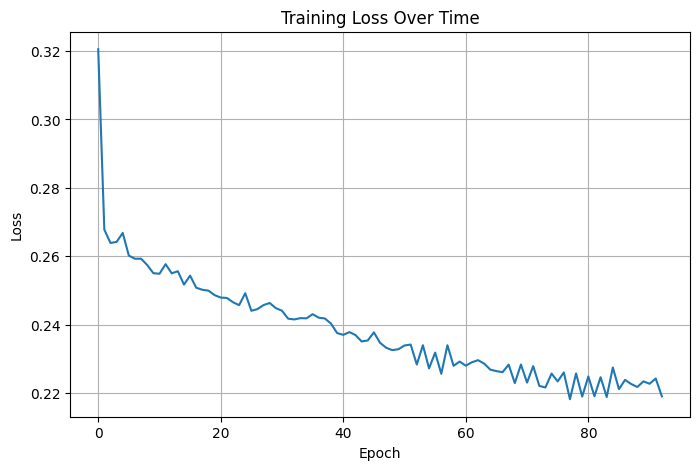

Final Loss: 0.2190


In [19]:
# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print(f'Final Loss: {train_losses[-1]:.4f}')

In [20]:
# 6. MODEL EVALUATION
model.eval()

test_losses = []
total_test_loss = 0
true_values = []
predictions = []

with torch.no_grad():  # Turn off back propagation
    for batch_X, batch_y in test_loader:
        # Move batch data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        y_eval, _, _ = model(batch_X)
        loss = criterion(y_eval, batch_y)
        
        test_losses.append(loss.item())
        total_test_loss += loss.item()

        # Store predictions and true_values for plotting
        predictions.append(y_eval.cpu().detach().numpy())
        true_values.append(batch_y.cpu().numpy())
    
avg_test_loss = total_test_loss / len(test_loader)

print(f'Average Test Loss: {avg_test_loss:.4f}')

# Compare with training loss
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Test Loss: {avg_test_loss:.4f}')


Average Test Loss: 0.3116
Final Training Loss: 0.2190
Test Loss: 0.3116


In [21]:
# Concatenate all batches
predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)

min_len = min(len(predictions), len(true_values))
predictions = predictions[:min_len]
true_values = true_values[:min_len]

# Verify shapes
print("Predictions shape:", predictions.shape)
print("Actual shape:", true_values.shape)

Predictions shape: (1455, 7)
Actual shape: (1455, 7)


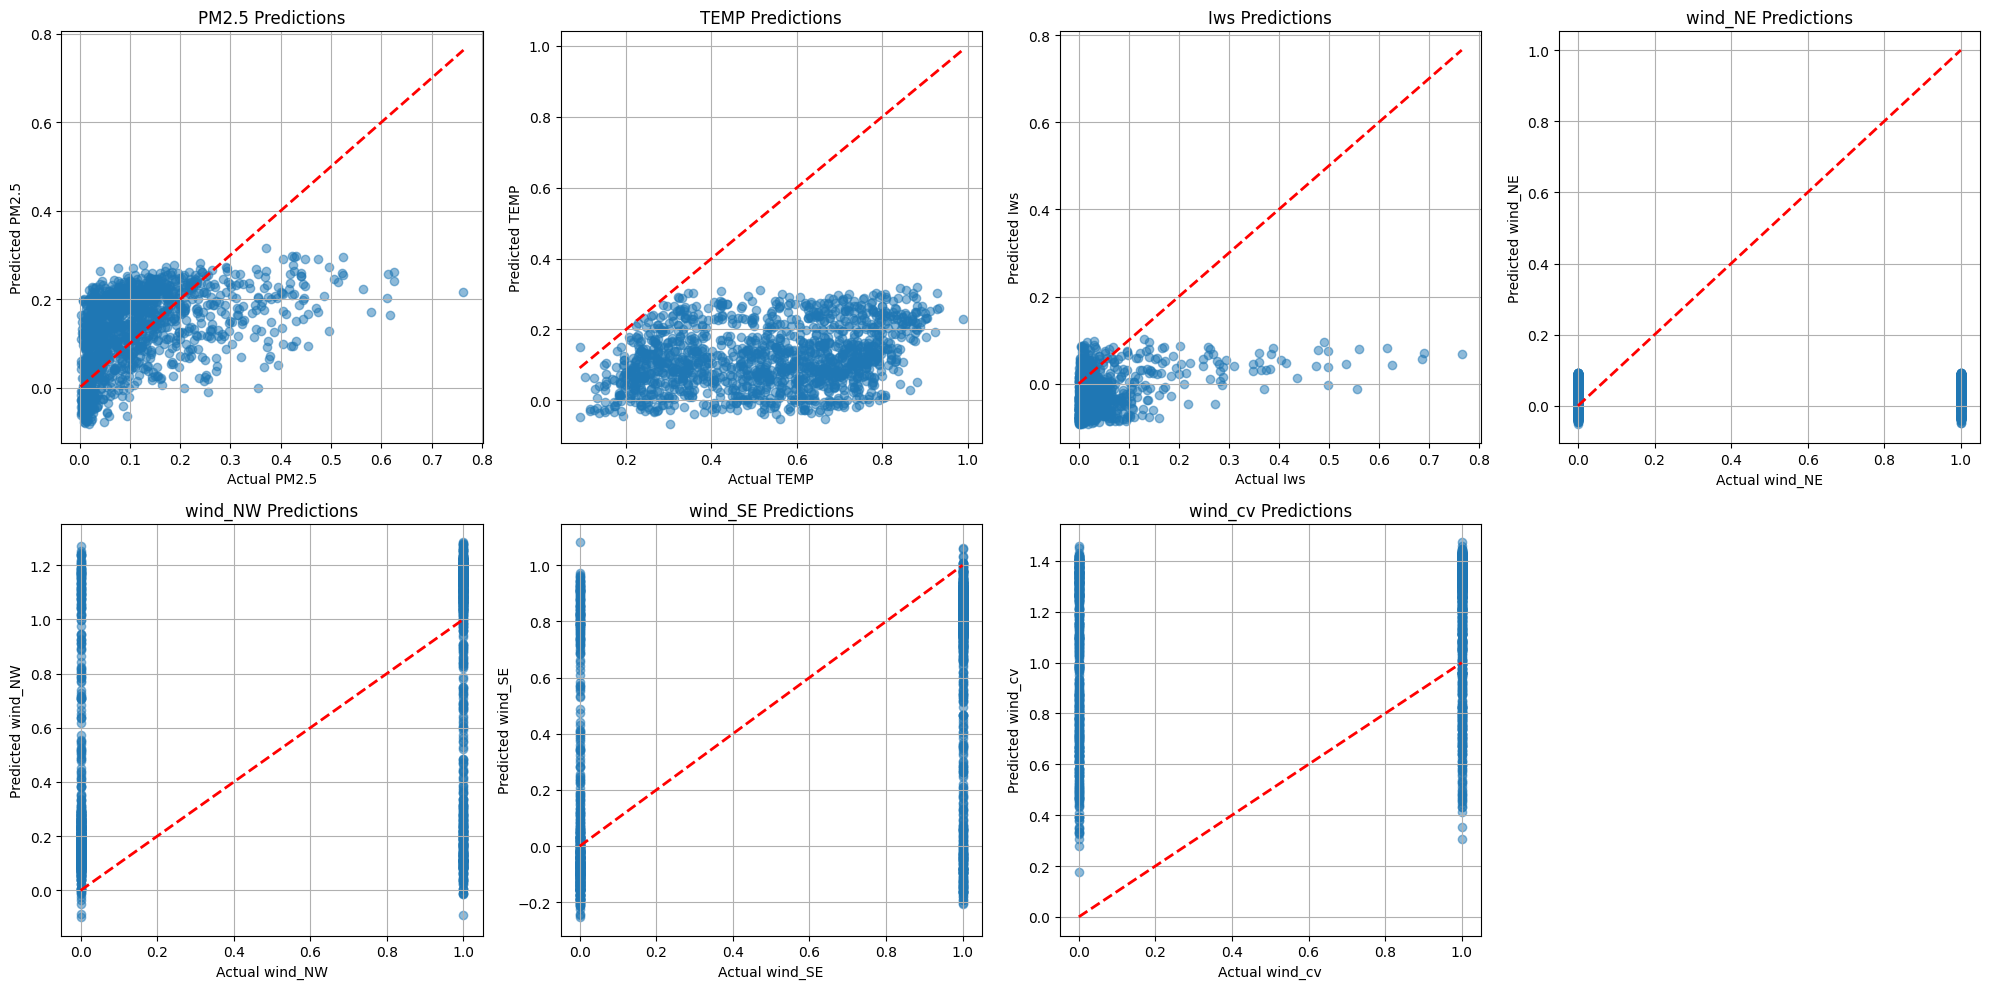

In [22]:
# 7. RESULTS & ANALYSIS
features = ['PM2.5', 'TEMP', 'Iws', 'wind_NE', 'wind_NW', 'wind_SE', 'wind_cv']
    
# Create subplots for each feature
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, feature in enumerate(features):
    if idx < len(features):  # Plot each feature
        # Scatter plot
        axes[idx].scatter(true_values[:, idx], predictions[:, idx], alpha=0.5)
        axes[idx].plot([true_values[:, idx].min(), true_values[:, idx].max()], 
                        [true_values[:, idx].min(), true_values[:, idx].max()], 
                        'r--', lw=2)
        axes[idx].set_xlabel(f'Actual {feature}')
        axes[idx].set_ylabel(f'Predicted {feature}')
        axes[idx].set_title(f'{feature} Predictions')
        axes[idx].grid(True)

# Remove last empty subplot if any
if len(features) < 8:
    fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

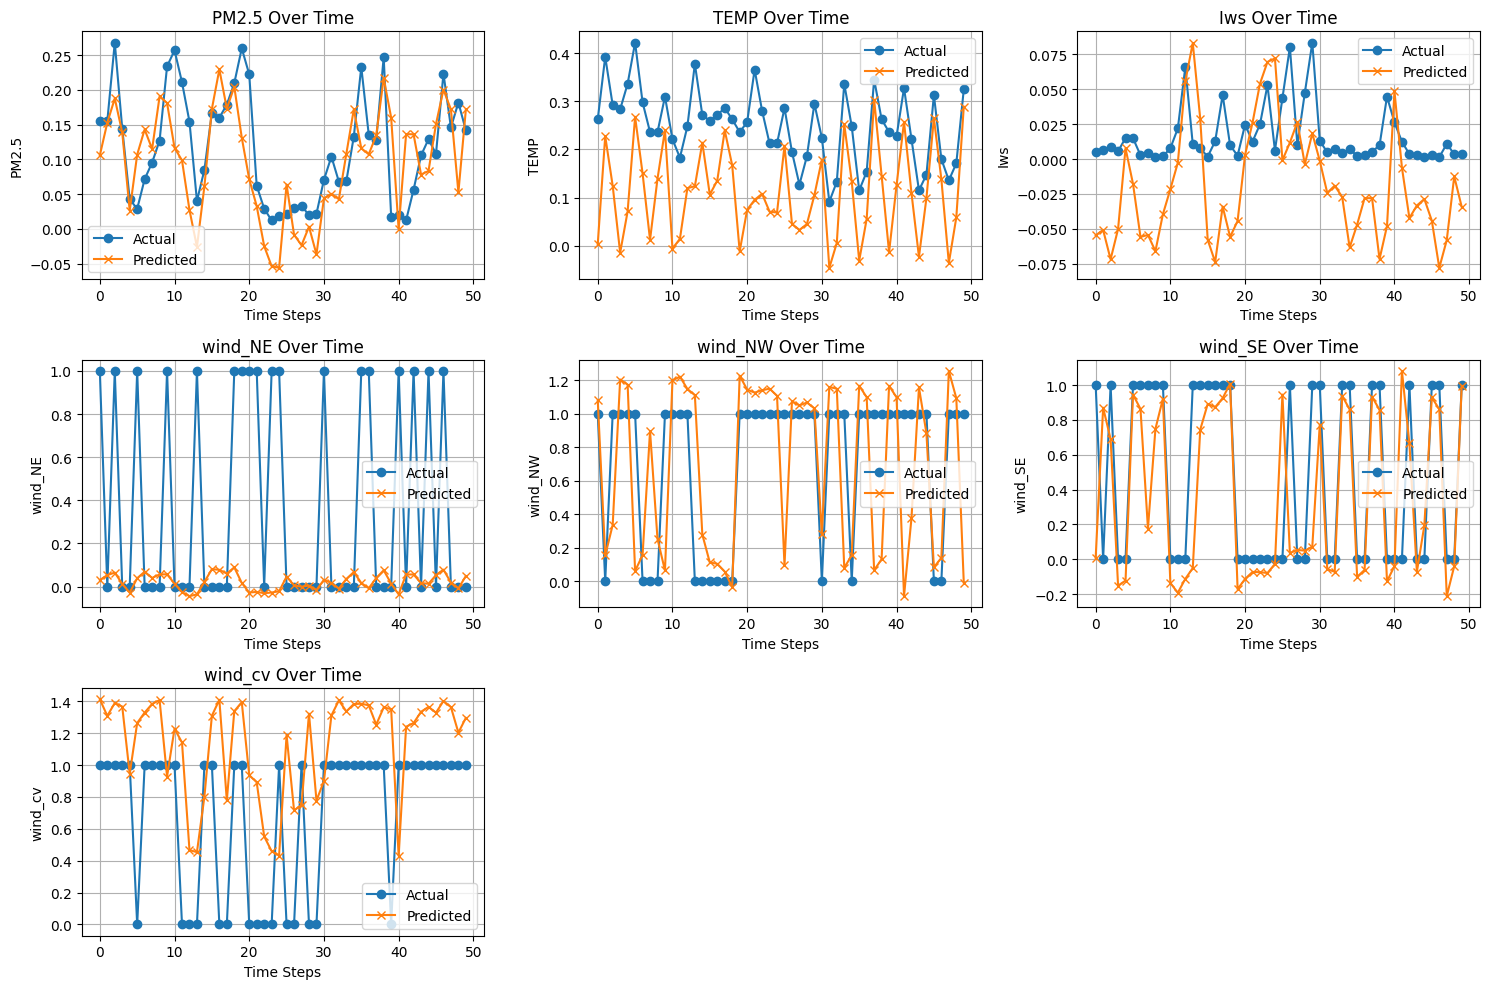

In [23]:
# Time series plot for first few samples
plt.figure(figsize=(15, 10))
for idx, feature in enumerate(features):
    plt.subplot(3, 3, idx+1)
    plt.plot(true_values[:50, idx], label='Actual', marker='o')
    plt.plot(predictions[:50, idx], label='Predicted', marker='x')
    plt.title(f'{feature} Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()